In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import seaborn as sns
from pylab import text
import numpy as np
import matplotlib.pyplot as plt
import io

# 2020 Data and Best Players

In [149]:
##Opening new file, scraping rotoguru pages by week, appending to file

f = open("2020_fantasy_points.txt", "w", newline='')
for year in range(2020,2021):
    for week in range(1,18):
        url = "http://rotoguru1.com/cgi-bin/fyday.pl?week="+str(week)+"&game=fd&year="+str(year)+"&scsv=1"
        r = requests.get(url)
        soup = BeautifulSoup(r.content, 'html.parser')
        data = soup.find_all('pre')[-1]

        f.write(data.text)
    
f.close()

In [150]:
##Creating df from  points data, removing headers

points_df = pd.read_csv("2020_fantasy_points.txt",delimiter = ";")
points_df = points_df[points_df['Week'] != 'Week']
points_df['FD salary'] = points_df['FD salary'].astype('float')
points_df['FD points'] = points_df['FD points'].astype('float')

##Drop nans and 0s
points_df = points_df.dropna()
points_df = points_df[points_df['FD salary'] != 0]

In [125]:
##Groupby Player
grouped_df = points_df.groupby(by='Name',as_index=False).mean()

0.702345509129821
0.7023455091298203


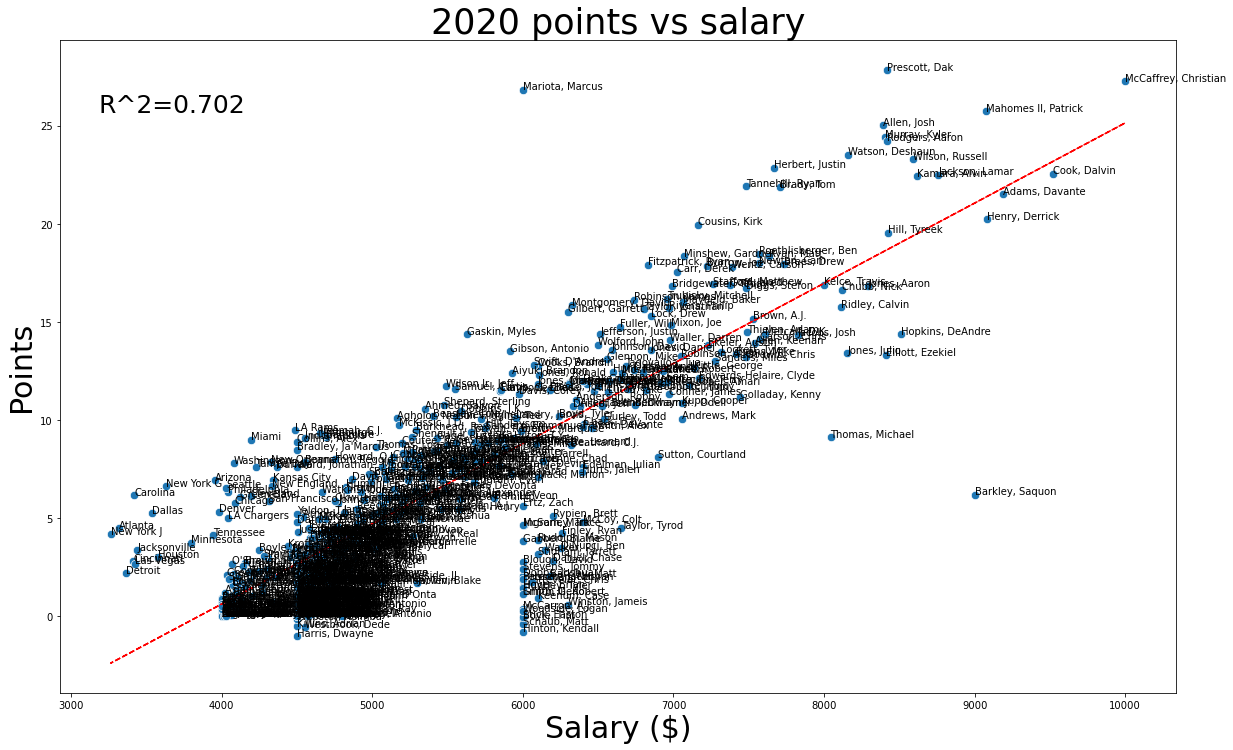

In [126]:
##Plot Points vs Salary, linear trend
x = grouped_df['FD salary']
y = grouped_df['FD points']

z, res, _, _, _ = np.polyfit(x, y, 1, full = True)
p = np.poly1d(z)

##R^2 value
yhat =   [p(z) for z in x]       # or [p(z) for z in x]
ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
r2 = (ssreg / sstot)
print(r2)

#r^2 value another way
SSE = res[0]
diff = y - y.mean()
square_diff = diff **2
SST = square_diff.sum()
r2 = 1 - SSE/SST
print(r2)

fig, ax = plt.subplots(figsize=(20,12))
sns.scatterplot(ax=ax,x='FD salary',y='FD points',data=grouped_df,s=70)

plt.title('2020 points vs salary',fontsize=35)
plt.xlabel('Salary ($)',fontsize=30)
plt.ylabel('Points',fontsize=30)

plt.plot(x,p(x),"r--")

for i,name in enumerate(grouped_df['Name']):
    ax.annotate(name,(x[i],y[i]))

text(0.1, 0.9,'R^2={}'.format('%.3f'%(r2)),fontsize=25,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
    
plt.show()

In [139]:
##Seeing which players are above or below trend line
grouped_df['trend y'] = p(grouped_df['FD salary'])
grouped_df['trend diff'] = grouped_df['FD points'] - grouped_df['trend y']

better_players_df = grouped_df[grouped_df['trend diff'] > 0]
better_players_df = better_players_df.sort_values(by=['FD points'],ascending=False)

In [140]:
better_players_df.shape

(301, 5)

In [141]:
better_players_df

,Name,FD points,FD salary,trend y,trend diff
460,"Prescott, Dak",27.828000,8420.000000,18.684916,9.143084
376,"McCaffrey, Christian",27.266667,10000.000000,25.139284,2.127382
372,"Mariota, Marcus",26.840000,6000.000000,8.799112,18.040888
369,"Mahomes II, Patrick",25.748571,9078.571429,21.375209,4.373362
11,"Allen, Josh",25.029333,8393.333333,18.575982,6.453351
...,...,...,...,...,...
39,"Bell, Blake",1.066667,4073.333333,0.928596,0.138071
16,"Anderson, Stephen",0.912500,4000.000000,0.629026,0.283474
438,"Parkinson, Colby",0.866667,4000.000000,0.629026,0.237640
141,"Deguara, Josiah",0.850000,4000.000000,0.629026,0.220974


# 2021 Week 1 Available Players

In [174]:
players_2021_df = pd.read_csv('2021_fd_salaries.csv')

In [175]:
players_2021_df

,Player,Pos,year,week,FD SALARY,Fantasy Score,Value Factor,Rank
0,"Brady, Tom",QB,2021,1,"$16,000",-,-,999
1,"Prescott, Dak",QB,2021,1,"$15,500",-,-,999
2,"Elliott, Ezekiel",RB,2021,1,"$14,000",-,-,999
3,"Evans, Mike",WR,2021,1,"$13,000",-,-,999
4,"Godwin, Chris",WR,2021,1,"$12,500",-,-,999
...,...,...,...,...,...,...,...,...
606,Houston,D,2021,1,"$3,400",-,-,999
607,Arizona,D,2021,1,"$3,400",-,-,999
608,Detroit,D,2021,1,"$3,300",-,-,999
609,Cleveland,D,2021,1,"$3,100",-,-,999


In [205]:
##Merge both "better_players_df" and "players_2021_df"
##Only have players that are both "better players" and players that we can select in Week 1 of 2021

new_df = better_players_df.merge(players_2021_df,how="inner", left_on='Name',right_on='Player')
new_df = new_df[['Name','FD SALARY','Pos','FD points']]

# Creating Team and Combining Both Data

In [275]:
##Create team as
# 1 QB
# 2 RB
# 3 WR
# 1 FLEX
# 1 TE
# 1 DEF

##Most fantasy points team - no price constraint

team = pd.DataFrame()

team = team.append(new_df[new_df['Pos'] == 'QB'].sort_values(by='FD points',ascending=False).iloc[0])
team = team.append(new_df[new_df['Pos'] == 'RB'].sort_values(by='FD points',ascending=False).iloc[0:2])
team = team.append(new_df[new_df['Pos'] == 'WR'].sort_values(by='FD points',ascending=False).iloc[0:3])
team = team.append(new_df[new_df['Pos'] == 'TE'].sort_values(by='FD points',ascending=False).iloc[0:1])


potential_list = new_df[(new_df['Pos'] == 'RB') | (new_df['Pos'] == 'WR') | (new_df['Pos'] == 'TE')].sort_values(by='FD points',ascending=False)[0:7]
guess = potential_list.iloc[0]
i = 0

while guess['Name'] in team['Name'].unique():
    i+=1
    guess = potential_list.iloc[i]
team = team.append(guess)
team = team.append(new_df[new_df['Pos'] == 'D'].sort_values(by='FD points',ascending=False).iloc[0:1])

print('-----TEAM: \n')
print(team)
print('\n')
price = team[team.columns[0:1]].replace('[\$,]', '', regex=True).astype(int).sum().values[0]
points = team['FD points'].sum()
print(f'---PRICE = $ {price}')
print('\n')
print(f'---POINTS = {points}')


-----TEAM: 

   FD SALARY  FD points                  Name Pos
0   $15,500   27.828000         Prescott, Dak  QB
1   $10,400   27.266667  McCaffrey, Christian  RB
8    $8,600   22.420000         Kamara, Alvin  RB
12   $8,500   19.542857          Hill, Tyreek  WR
22   $7,900   16.726667         Diggs, Stefon  WR
29   $7,800   15.164286           Brown, A.J.  WR
76   $5,400    9.412500        Tonyan, Robert  TE
24   $5,900   16.135714       Robinson, James  RB
78   $4,000    9.250000            Pittsburgh   D


---PRICE = $ 74000


---POINTS = 163.74669047619048


In [ ]:

##Most expensive team

True